<a href="https://colab.research.google.com/github/efeslab/dynamoChannel/blob/main/fingerprinting/microbenchmarks_testfiles_classify/FFNN_Tabular_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation

In [2]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 03:33:05


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports and General Functions

In [4]:
def IsNotebook():
    """Indicate the shell name, whether code is running on a notebook, and if so whether it's hosted on googlecolab."""
    isnotebook, isgooglecolab, shell = None, None, None
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            isnotebook, isgooglecolab = True, False   # Jupyter notebook or qtconsole
        elif shell == "Shell":
            isnotebook, isgooglecolab = True, True    # Google Colab
        elif shell == 'TerminalInteractiveShell':
            isnotebook, isgooglecolab = False, False  # Terminal running IPython
        else:
            isnotebook, isgooglecolab = False, False  # Other type (?)
    except NameError:
        isnotebook, isgooglecolab = False, False      # Probably standard Python interpreter
    return shell, isnotebook, isgooglecolab
shell, isnotebook, isgooglecolab = IsNotebook()
if isnotebook and not isgooglecolab: #If we are in a notebook but not on google colab, let's use all the available screen
    from IPython.display import display, HTML
    display(HTML("<style>.container { width:99% !important; }</style>"))
    if not isgooglecolab:
        try: #Using the jedi completer takes too long to complete words
            %config Completer.use_jedi = False
        except:
            pass
if isgooglecolab: #If we are in a google colab environment, we probably need to mount our google drive
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except Exception as e:
        print(e)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#######################
### General Imports ###
import os #Making sure we're using all CPU cores for faster calculations
IsWindows = os.name == 'nt'
os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())
os.environ["OPENBLAS_NUM_THREADS"] = str(os.cpu_count())
os.environ["MKL_NUM_THREADS"] = str(os.cpu_count())
os.environ["VECLIB_MAXIMUM_THREADS"] = str(os.cpu_count())
os.environ["NUMEXPR_NUM_THREADS"] = str(os.cpu_count())

import sys #Printing version for posterity
print("Python version:", sys.version)

try: #Allows saving and loading of variables
    import pickle5 as pickle
except:
    import pickle
try: #Printing version for posterity
    print("Pickle version:", pickle.__version__)
except:
    print("Pickle version:", pickle.format_version)
    
import dill as dill #Allows even deeper saving (associated classes, etc., as well)
print("Dill version:", dill.__version__)

import warnings #Ability to create custom warnings, like warnings.warn("deprecated", DeprecationWarning)
import itertools #Needed for Confusion Matrix

if IsWindows:
    import winsound #Uses the computer's speakers to alert you (e.g. when training is done)
from tqdm import tqdm #Iterations can show a progress bar (like in Training)
from collections import Counter #Allows for frequency counting similar with R's "table"
from collections import OrderedDict
#######################


#####################
### Date and Time ###
import time #Gets the current time
from pytz import timezone #Allows for timezones to be set. #pytz.all_timezones
from datetime import datetime #Allows for Datetime objects like current Datetime. #datetime.fromisoformat('2021-05-24')
#There's also: np.datetime64('2021-08-01')
#####################


###################
### Mathematics ###
import numpy as np #Working with numeric arrays
print("Numpy version:", np.__version__)
###################


#######################################
### Statistics and Machine Learning ###
#Utility
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler #Various ways of scaling the data
from sklearn.model_selection import train_test_split

#ML
from sklearn.decomposition import PCA

#Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
#######################################


##################
### Dataframes ###
import pandas as pd
##################


#############
### Plots ###
import matplotlib.pyplot as plt #Allows use of Pyplot plots

import seaborn as sns #Allows use of Seaborn plots
sns.set() #Sets default plot theme

from matplotlib.ticker import AutoMinorLocator, MultipleLocator
#############


#########################
### Images / Pictures ###
from PIL import Image
#########################


######################
### String or Text ###
import json #Can encode or decode JSON string objects
import string #Provides functions for strings
######################


###################################
### Files, Directories, Folders ###
import csv

from pathlib import Path
###################################


################################
### Neural Network Libraries ###
#General
import torch
import torch.nn as nn
# from torchsummary import summary
if isgooglecolab:
    !pip install torchinfo
from torchinfo import summary

#Data
from torch.utils.data import Dataset, TensorDataset, DataLoader

#Images
from torchvision import datasets, transforms, models

#Info and configuration
print()
print(f"PyTorch v{torch.__version__}")
IS_GPU_AVAILABLE = torch.cuda.is_available()
print(f"CUDA device available: {IS_GPU_AVAILABLE}")
if (torch.cuda.is_available()):
    print(f"{torch.cuda.device_count()} devices available")
    for n in range(torch.cuda.device_count()):
        print("\t" + torch.cuda.get_device_name(n))
    print(f"cuda: {torch.cuda.current_device()}") #It can give you information like the GPU is not supported
print("Num threads set to:", os.cpu_count())
torch.set_num_threads(os.cpu_count())
################################


########################
### Useful functions ###
if "OrigFigSize" not in locals() and "OrigFigSize" not in globals(): #Just in case Initialisation is re-run after any of these have chaned
    OrigFigSize   = plt.rcParams["figure.figsize"]

NonNans = lambda List: List[np.logical_not(np.isnan(List))]
LastNonNan = lambda List: NonNans(List)[-1] if np.sum(np.isnan(List)) < len(List) else np.array([]) if type(List) == np.ndarray else []

def ZeroANumber(Number, MaxLength, ForceMaxLength = False):
    """Take a single Number and prepend '0's to it until it meets MaxLength, or if ForceMaxLength then also clip digits from the end until it meets MaxLength."""
    res = str(Number).zfill(MaxLength)
    if ForceMaxLength: res = res[:MaxLength]
    return res

def SpaceAString(CurString, MaxLength, SpaceTheFront = True, ForceMaxLength = False, ForceRemoveFromFront = False):
    """Prepend/Append (SpaceTheFront) spaces to CurString until it meets ForceMaxLength or if ForceMaxLength also Clip characters from the beginning/end (ForceRemoveFromFront) until it meets ForceMaxLength."""
    CurLen = len(CurString)
    Result = CurString
    
    if CurLen < MaxLength:
        if SpaceTheFront:
            Result = (" " * (MaxLength-CurLen)) + CurString
        else:
            Result = CurString + (" " * (MaxLength-CurLen))
    elif CurLen > MaxLength and ForceMaxLength:
        if ForceRemoveFromFront:
            Result = CurString[(CurLen - MaxLength):]
        else:
            Result = CurString[:-(CurLen - MaxLength)]
    return Result

def WriteText(TextParsableVar, FullFilePath):
    """Take a string (or string-parsable variable) and save it as text file on the directory and with a name indicated by FullFilePath."""
    try:
        DirName = Path(FullFilePath).parent.absolute()
        os.makedirs(DirName, exist_ok = True)
        
        FileOptions = open(FullFilePath, "w")
        FileOptions.writelines(
            f"{TextParsableVar}"
        )
    except Exception as e:
        print(f"Exception:\n{e}")
    finally:
        try:
            FileOptions.close()
        except Exception:
            pass
SaveText = lambda TextParsableVar, FullFilePath: WriteText(TextParsableVar, FullFilePath) #Alias for WriteText to be the same as Save/Load Variable

def ReadText(FullFilePath):
    """Read the string content of a text file given by FullFilePath and return it as a string."""
    with open(FullFilePath, "r+", encoding = "utf8") as io:
        TextString = io.read()
    return TextString
LoadText = lambda FullFilePath: ReadText(FullFilePath) #Alias for ReadText to be the same as Save/Load Variable

def ReadTextLines(FullFilePath):
    """Read the string content of a text file given by FullFilePath and return it as a string."""
    with open(FullFilePath, "r+", encoding = "utf8") as io:
        TextString = io.readlines()
    return TextString
LoadTextLines = lambda FullFilePath: ReadTextLines(FullFilePath) #Alias for ReadTextLines to be the same as Save/Load Variable

def SaveVariable(Variable, FileName):
    """Create the directory path for and pickle Variable under FileName."""
    DirName = Path(FileName).parent.absolute()
    os.makedirs(DirName, exist_ok = True)
    with open(FileName, 'wb') as io:
        pickle.dump(Variable, io)

def SaveVariableDill(Variable, FileName):
    """Create the directory path for and deep-save Variable under FileName using dill."""
    DirName = Path(FileName).parent.absolute()
    os.makedirs(DirName, exist_ok = True)
    with open(FileName, 'wb') as io:
        dill.dump(Variable, io)
    
def LoadVariable(FileName):
    """Un-pickle a binary file saved under FileName and return it as a variable."""
    with open(FileName, "rb") as io:
        Res = pickle.load(io)
    return Res

def LoadVariableDill(FileName):
    """Read the content of a binary file saved under FileName and return it as a variable."""
    with open(FileName, 'rb') as io:
        Res = dill.load(io)
    return Res

def RemLastLine(s):
    """Remove the last line in the string s."""
    return s[:s.rfind('\n')]
########################

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu" #To FORCE CPU
print("device=", device)

Python version: 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
Pickle version: 4.0
Dill version: 0.3.6
Numpy version: 1.21.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

PyTorch v1.13.1+cu116
CUDA device available: True
1 devices available
	A100-SXM4-40GB
cuda: 0
Num threads set to: 12
device= cuda


## Architecture

In [6]:
#FeedForward Neural Network
class Net(nn.Module):
    def __init__(self, K_Length, num_units, activation, dropout, usebias):
        super(Net, self).__init__()
        self.K_Length = K_Length
        self.num_units = num_units
        self.activation = activation
        self.dropout = dropout
        self.usebias = usebias        
        
        self.layers = nn.ModuleList([
            nn.Linear(in_features = self.num_units[0], out_features = self.num_units[1], bias = self.usebias[0]),
            nn.Dropout(p = self.dropout[0], inplace = False),
            self.GetActivationLayer(0),
            nn.Linear(in_features = self.num_units[1], out_features = self.num_units[2], bias = self.usebias[0]),
            nn.Dropout(p = self.dropout[0], inplace = False),
            self.GetActivationLayer(0),
            nn.Linear(in_features = self.num_units[2], out_features = self.num_units[3], bias = self.usebias[1]),
            nn.Dropout(p = self.dropout[1], inplace = False),
            self.GetActivationLayer(1),
            nn.Linear(in_features = self.num_units[3], out_features = self.num_units[4], bias = self.usebias[2]),
            nn.Dropout(p = self.dropout[2], inplace = False),
            self.GetActivationLayer(2),
            nn.Linear(in_features = self.num_units[4], out_features = self.K_Length, bias = self.usebias[3])
        ])
    
    def forward(self, x):
        output = x.view(x.size(0), -1)
        output = self.layers[0](output)
        output = self.layers[1](output)
        output = self.layers[2](output)
        output = self.layers[3](output)
        output = self.layers[4](output)
        output = self.layers[5](output)
        output = self.layers[6](output)
        output = self.layers[7](output)
        output = self.layers[8](output)
        output = self.layers[9](output)
        output = self.layers[10](output)
        output = self.layers[11](output)
        output = self.layers[12](output)
        return output
    
    def GetActivationLayer(self, layer):
        Result = None
        if (self.activation[layer] == "relu"): #Not differentiable at 0. Doesn't need Greedy layer-wise pretraining (Hinton) because it doesn't suffer from vanishing gradient
            Result = nn.LeakyReLU(ReluAlpha) if ReluAlpha != 0 else nn.ReLU() #alpha: Controls the angle of the negative slope
        elif (self.activation[layer] == "relu6"):
            Result = nn.ReLU6()
        elif (self.activation[layer] == "elu"): #Like ReLu but allows values to be negative, so they can be centred around 0, also potential vanishing gradient on the left side but doesn't matter
            Result = nn.ELU(alpha = EluAlpha) #alpha: Slope on the left side
        elif (self.activation[layer] == "tanh"): #Suffers from Vanishing Gradient
            Result = nn.Tanh()
        elif (self.activation[layer] == "sigmoid"): #Suffers from Vanishing Gradient
            Result = nn.Sigmoid() #Result isn't centred around 0. Maximum derivative: 0.25
        return Result
print("Done")

Done


## Dataset Functions

In [7]:
def train_valid_test_split(X_Data, train_size, valid_size, Y_Data = None, random_state = None, shuffle = True, stratify = None):
    """Split the dataset, optionally in a stratified manner, into a Train, Validation and Test set"""
    
    if (type(train_size) == int and sum([train_size, valid_size]) >= len(X_Data)) or (type(train_size) != int and sum([train_size, valid_size]) >= 1):
        raise ValueError(f"The train_size [{train_size}] + the valid_size [{valid_size}] should sum up to less than 100% so that there's some percentage left for the test set")
    
    TrainIdx, ValidTestIdx = train_test_split(np.arange(len(X_Data)), train_size = train_size, shuffle = shuffle, stratify = stratify, random_state = random_state)
    TrainX     = X_Data[TrainIdx]
    ValidTestX = X_Data[ValidTestIdx]
    if Y_Data is not None:
        TrainY     = Y_Data[TrainIdx]
        ValidTestY = Y_Data[ValidTestIdx]
    
    if type(train_size) != int: #For the 2nd split we need the validation percent relative to the Valid/Test portion of the dataset alone
        test_size  = 1 - train_size - valid_size #Actual test size
        valid_size = 1 - (test_size / (valid_size + test_size)) #Relative (to ValidTest) valid size
        test_size  = 1 - valid_size #Relative (to ValidTest) test size
    
    if Y_Data is not None:
        ValidX, TestX, ValidY, TestY = train_test_split(ValidTestX, ValidTestY, train_size = valid_size, shuffle = shuffle, stratify = stratify[ValidTestIdx] if stratify is not None else None, random_state = random_state)
        return TrainX, ValidX, TestX, TrainY, ValidY, TestY
    else:
        ValidX, TestX = train_test_split(ValidTestX, train_size = valid_size, shuffle = shuffle, stratify = stratify[ValidTestIdx] if stratify is not None else None, random_state = random_state)
        return TrainX, ValidX, TestX

## Optimisation Functions

In [8]:
def ClassAccMulti(Targets, Preds, K):
    """Calculate the Class-Wise accuracy for a multi-class task"""
    return(np.mean([(Targets == k) == (Preds == k) for k in range(K)]))

In [9]:
def AccCalculation(Y_Hat, Targets):    
    """Calculate the Accuracy given the Actual values and Predictions for Binary and Multiclass Classification."""
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
        
    return np.mean(Y_Hat == Targets)

In [10]:
def AUCCalculation(Targets, Y_Prob, Y_Hat, Verbose = True):
    """Calculate the Area Under the Receiver Operating Characteristic Curve given the Actual values and Predictions for Binary and Multiclass Classification using sklearn's roc_auc_score()."""
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Prob, torch.Tensor):
        Y_Prob = Y_Prob.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
    
    try:
        CurMetric2 = roc_auc_score(Targets, Y_Prob, multi_class = "ovr", average = 'weighted') #Calculating Weighted AUC #Cares for performance both in Positives and Negatives (but may not fare well with heavy class imbalance)
    except Exception as exc:
        CurMetric2 = np.nan
        if Verbose:
            warnings.warn(f"\nAn error occurred in AUC calculation (probably because of missing classes in the random batch of data?).\nThe error reads: {exc}")
            print("AUC Warning. set(Targets):", list(set(Targets.reshape(-1))), "set(Outputs): ", list(set(Y_Hat.reshape(-1))))
            
    return CurMetric2

In [11]:
def F1ScoreCalculation(Targets, Y_Hat):
    """Calculate the F1 score given the Actual values and Predictions for Binary and Multiclass Classification using sklearn's f1_score()."""
    if isinstance(Targets, torch.Tensor):
        Targets = Targets.cpu().numpy()
    
    if isinstance(Y_Hat, torch.Tensor):
        Y_Hat = Y_Hat.cpu().numpy()
    
    try:
        CurMetric3 = f1_score(Targets, Y_Hat, average = 'weighted') #Calculating Weighted F1 #Cares about balance between Precision and Recall (Sensitivity)
    except Exception as exc:
        CurMetric3 = np.nan
        warnings.warn(f"\nAn error occurred in F1 score calculation (probably because of missing classes in the random batch of data?).\nThe error reads: {exc}")
            
    return CurMetric3

In [12]:
def PrintIterationMetrics(it, epochs, t0, train_loss, test_loss, first_metric, first_metric_Name, second_metric, second_metric_Name, third_metric, third_metric_Name, MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len):
    """Print information about the Current Epoch, Train/Test losses as well as metrics and duration, and return the Max length of each metric viewed as a string in order to keep a consistent text alignment amongst consecutive epochs."""
    dt = datetime.now() - t0

    strTrainLoss = f"{train_loss:.4f}"
    strTestLoss = f"{test_loss:.4f}"
    strMetric1 = f'{first_metric:.3f}'
    strMetric2 = f'{second_metric:.3f}'
    strMetric3 = f'{third_metric:.3f}'
    if it == 0:
        MaxTrainLossLen = len(strTrainLoss)
        MaxTestLossLen = len(strTestLoss)
        MaxMetric1Len = len(strMetric1)
        MaxMetric2Len = len(strMetric2)
        MaxMetric3Len = len(strMetric3)
    print(f'Epoch {ZeroANumber(it+1, len(str(epochs)))}/{epochs}, Train Loss: {SpaceAString(strTrainLoss, MaxTrainLossLen)}, Test Loss: {SpaceAString(strTestLoss, MaxTestLossLen)} | {first_metric_Name}: {SpaceAString(strMetric1, MaxMetric1Len)}, {second_metric_Name}: {SpaceAString(strMetric2, MaxMetric1Len)}, {third_metric_Name}: {SpaceAString(strMetric3, MaxMetric1Len)}, Duration: {dt}')
    return MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len

In [13]:
def UpdateMetricsAndSaveModel(model, train_loss, test_loss, train_best_loss, test_best_loss, CurMetric1, Metric1, CurMetric2, Metric2, CurMetric3, Metric3):
    """if current model outperform's best model, save current model's state and update best performance metrics to reflect this model's."""
    if (test_loss < test_best_loss): #Saving the model if it outperforms previous iteration's model
        test_best_loss = test_loss
        train_best_loss = train_loss
        torch.save(model.state_dict(), f"model_dict.pt") #Saving Model's Dictionary
        
        if np.isfinite(CurMetric1) and CurMetric1 >= Metric1:
            Metric1 = CurMetric1
            Metric2 = CurMetric2
            Metric3 = CurMetric3
            torch.save(model.state_dict(), f"acc_model_dict.pt") #Saving Model's Dictionary
    return train_best_loss, test_best_loss, Metric1, Metric2, Metric3

In [14]:
def PrintFinishingInformation(start_time, JustCalculateElapsedTime = False):
    """Calculate and print (and return) the elapsed time over all the training epochs."""
    elapsed_time = time.time() - start_time
    if not JustCalculateElapsedTime:
        FinishedOn = datetime.now(timezone('Europe/Athens')).strftime("%a, %Y-%m-%d %H:%M %Z %z")
        print("Done (" + FinishedOn + ") Elapsed time: " + str(round(elapsed_time, 1)) + " seconds")
    
    return elapsed_time

In [15]:
def TrainModel(model, optimiser, criterion, X_Train, Y_Train):
    """Train by calculating the gradients and taking one step."""
    model.train() #Putting model in training mode so that things like dropout() are activated again
    
    optimiser.zero_grad() #Initialisation of the gradient of θ
    outputs = model(X_Train) #Getting the prediction using the forward direction of the Neural Net
    
    loss = criterion(outputs, Y_Train) #Calculating the loss according to the loss function
    loss.backward() #Calculating the Gradient Δθ of the loss function with respect to the parameters
    
    optimiser.step() #Calculates and updates the parameters θ using gradient descent, as θ = θ - η*Δθ
    
    return optimiser, outputs, loss

In [16]:
def EvaluateModelFromPreds(criterion, Y_Prob, Targets, Verbose):
    """Use the forward direction of the model following with a sigmoid+threshold or softmax+argmax for binary or multiclass classification respectively, and calculate and return the predictions and evaluation metrics."""
    with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
        loss_scalar = criterion(Y_Prob, Targets).item() #Calculating the loss according to the loss function
        
        Y_Prob = nn.Softmax(dim = 1)(Y_Prob) #dim: every slice along dim will sum to 1
        _, Y_Hat = torch.max(Y_Prob, 1) #Prediction. torch.max returns both max (value) and argmax (index)

        CurMetric1, CurMetric2, CurMetric3 = GetCategoricalMetrics(Y_Prob, Y_Hat, Targets, Verbose = Verbose)
        return loss_scalar, CurMetric1, CurMetric2, CurMetric3

In [17]:
def EvalForwardPass(model, inputs, criterion = None, Targets = None): #This is used at the very end on "Evaluation" Section. Unifies the forward pass, but doesn't calculate loss/metrics like EvaluateModel() does as we need greater granularity.
    """Use the forward direction of the model, potentially following with a sigmoid+threshold or softmax+argmax for binary or multiclass classification respectively."""
    
    if Targets is not None and criterion is None:
        warnings.warn(f"\nTargets are present but loss cannot be calculated because criterion is None.")
        
    model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated
    with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
        Y_Prob = model(inputs) #Getting the prediction using the forward direction of the Neural Net
        
        if Targets is not None:
            loss_scalar = criterion(Y_Prob, Targets).item() #Calculating the loss according to the loss function

        Y_Prob = nn.Softmax(dim = 1)(Y_Prob) #dim: every slice along dim will sum to 1
        _, Y_Hat = torch.max(Y_Prob, 1) #Prediction. torch.max returns both max (value) and argmax (index)
        
    if Targets is not None:
        return Y_Prob, Y_Hat, loss_scalar
    else:
        return Y_Prob, Y_Hat

In [18]:
def FixFormatAndDTypes(device, Inputs, Targets):
    """Ensure that the Inputs and Targets are Torch Tensors and of the correct shape and dtype before returning them."""
    if isinstance(Inputs, np.ndarray):
        Inputs = torch.from_numpy(Inputs)
    if isinstance(Targets, np.ndarray):
        Targets = torch.from_numpy(Targets)
    
    Inputs = Inputs.squeeze().to(device)
    Targets = Targets.squeeze().long().to(device)
    
    return Inputs, Targets

## Evaluation Functions

In [53]:
def plot_confusion_matrix(cm, classes, normalise = False, title = 'Confusion matrix', colourmap = plt.cm.Blues):
    """Plot the Confusion Matrix object returned by sklearn's confusion_matrix() and normalise it if normalise==True."""
    plt.grid(False)
    if normalise:
        print('Confusion matrix')
        print(cm)
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        plt.imshow(cm, interpolation = 'nearest', cmap = colourmap)
        plt.clim(0.0, 1.0)
    else:
        plt.imshow(cm, interpolation = 'nearest', cmap = colourmap)
    #plt.title(title)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalise else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True File Name')
    plt.xlabel('Predicted File Name')

    # these 4 lines are for the microbenchmark figure:
    plt.ylabel('True File Name', fontsize=22)
    plt.xlabel('Predicted File Name', fontsize=22)
    plt.rcParams.update({'font.size': 32})
    plt.tick_params(axis='both', labelsize=22)

    plt.savefig(f"{path_fig}/confusion_matrix.png")
    plt.savefig(f"{path_fig}/confusion_matrix.pdf", format="pdf", bbox_inches="tight")

    plt.show()

def PlotHistory(Train_History, Test_History = None, Key = "Loss", figsize = (12, 8), MajorLineStyle = "--", MinorLineStyle = ":", MajorLines = 10, MinorInbetweenLinesEvery = 4, test_alpha = 1.0):
    """Plot a juxtaposition of a Train and Test metric (parametrised by Key), usually 'Loss'"""
    fig, ax = plt.subplots(figsize = figsize)
    plt.plot(Train_History, label = f"Train {Key}")
    if (Test_History is not None):
        plt.plot(Test_History, label = f"Test {Key}", alpha = test_alpha)
    xfrom, xto = ax.get_xlim()
    yfrom, yto = ax.get_ylim()
    ax.xaxis.set_major_locator(MultipleLocator(int(np.ceil((xto-xfrom)/MajorLines))))
    ax.yaxis.set_major_locator(MultipleLocator((yto-yfrom)/MajorLines))
    ax.xaxis.set_minor_locator(AutoMinorLocator(MinorInbetweenLinesEvery))
    ax.yaxis.set_minor_locator(AutoMinorLocator(MinorInbetweenLinesEvery))
    ax.grid(which = 'major', color='#FFFFFF', linestyle = MajorLineStyle)
    ax.grid(which = 'minor', color='#CCCCCC', linestyle = MinorLineStyle)
    plt.legend()
    plt.show()
    return None

def PlotAllMetrics(Titles, TrainMetrics, TestMetrics = None, figsize = [19, 13], test_alpha = 1.0):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = figsize)
    ax1.set_title(Titles[0])
    ax1.plot(TrainMetrics[0], label = f"Train")
    if TestMetrics is not None:
        ax1.plot(TestMetrics[0], label = f"Test", alpha = test_alpha)
    ax1.legend()
    ax2.set_title(Titles[1])
    ax2.plot(TrainMetrics[1], label = f"Train")
    if TestMetrics is not None:
        ax2.plot(TestMetrics[1], label = f"Test", alpha = test_alpha)
    ax2.legend()
    ax3.set_title(Titles[2])
    ax3.plot(TrainMetrics[2], label = f"Train")
    if TestMetrics is not None:
        ax3.plot(TestMetrics[2], label = f"Test", alpha = test_alpha)
    ax3.legend()
    ax4.set_title(Titles[3])
    ax4.plot(TrainMetrics[3], label = f"Train")
    if TestMetrics is not None:
        ax4.plot(TestMetrics[3], label = f"Test", alpha = test_alpha)
    ax4.legend()
    plt.show()
    return None

In [20]:
def PlotPerClassMetrics(K_Length, PerClassAccuracy, PerClassAUC, PerClassF1, Labels = None):
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(1, 3, figsize = [min(1.2 * K_Length, 13.3) * 3, 4], sharey = True)
    if Labels is not None:
        sn1 = sns.barplot(ax = ax1, x = Labels, y = np.round(PerClassAccuracy, 3)) #Names might not fit if names or along or too many
    else:
        sn1 = sns.barplot(ax = ax1, x = list(range(K_Length)), y = PerClassAccuracy)
    for i in sn1.containers:
        sn1.bar_label(i,)
    ax1.set_title("Classes' Accuracies")
    ax1.set_xlabel("Class")
    ax1.set_ylabel("Accuracy")

    if Labels is not None:
        sn2 = sns.barplot(ax = ax2, x = Labels, y = np.round(PerClassAUC, 3)) #Names might not fit if names or along or too many
    else:
        sn2 = sns.barplot(ax = ax2, x = list(range(K_Length)), y = PerClassAUC)
    for i in sn2.containers:
        sn2.bar_label(i,)
    ax2.set_title("Classes' AUCs")
    ax2.set_xlabel("Class")
    ax2.set_ylabel("AUC")

    if Labels is not None:
        sn3 = sns.barplot(ax = ax3, x = Labels, y = np.round(PerClassF1, 3)) #Names might not fit if names or along or too many
    else:
        sn3 = sns.barplot(ax = ax3, x = list(range(K_Length)), y = PerClassF1)
    for i in sn3.containers:
        sn3.bar_label(i,)
    ax3.set_title("Classes' F1s")
    ax3.set_xlabel("Class")
    ax3.set_ylabel("F1")

    plt.show()

def PlotPerClassROCCurve(K_Length, TrueClasses, Preds_prob, Labels = None):
    Width  = int(np.ceil(np.sqrt(K_Length))) + 1
    Height = int(np.floor(np.sqrt(K_Length)))
    fig, ax = plt.subplots(Height, Width, figsize = [min(5 * Width, 40), min(5 * Height, 40)])
    if Height == 1:
        ax = [ax]
    k = -1
    for HeightIdx in range(Height):
        for WidthIdx in range(Width):
            k += 1
            cur_ax = RocCurveDisplay.from_predictions(TrueClasses[k], Preds_prob[:, k], ax = ax[HeightIdx][WidthIdx])
            ax[HeightIdx][WidthIdx].set_title(f"{Labels[k] if Labels is not None else k}")
            ax[HeightIdx][WidthIdx].plot(np.linspace(0, 1, num = 20), np.linspace(0, 1, num = 20), 'b--')
            if (k + 1) >= K_Length:
                break
    plt.show()

def PlotPerClassPRCurve(K_Length, TrueClasses, Preds_prob, Labels = None):
    Width  = int(np.ceil(np.sqrt(K_Length))) + 1
    Height = int(np.floor(np.sqrt(K_Length)))
    fig, ax = plt.subplots(Height, Width, figsize = [min(5 * Width, 40), min(5 * Height, 40)])
    if Height == 1:
        ax = [ax]
    k = -1
    for HeightIdx in range(Height):
        for WidthIdx in range(Width):
            k += 1
            cur_ax = PrecisionRecallDisplay.from_predictions(TrueClasses[k], Preds_prob[:, k], ax = ax[HeightIdx][WidthIdx])
            ax[HeightIdx][WidthIdx].set_title(f"{Labels[k] if Labels is not None else k}")
            ax[HeightIdx][WidthIdx].plot(1 - np.linspace(0, 1, num = 20), np.linspace(0, 1, num = 20), 'b--')
            if (k + 1) >= K_Length:
                break
    plt.show()

In [21]:
def GetCategoricalMetrics(Y_Prob, Y_Hat, Targets, Verbose = True):
    """Calculate Categorical variable metrics (Accuracy, Area Under the Curve, F1 score) given the class Probability vector (binary) / matrix (multiclass), the class index (0 to K-1), and the Actual values."""
    test_Acc = AccCalculation(Y_Hat, Targets)
    test_AUC = AUCCalculation(Targets, Y_Prob, Y_Hat, Verbose = Verbose)
    test_F1 = F1ScoreCalculation(Targets, Y_Hat)
    
    return test_Acc, test_AUC, test_F1

In [22]:
def PlotCategoricalMetrics(Y_Hat, Targets, ClassNames, Normalise, figsize = None):
    """Plots the Confusion matrix given the class index (0 to K-1), and the Actual values."""
    PrevFigSize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = figsize if figsize is not None else PrevFigSize
    
    cm = confusion_matrix(Targets, Y_Hat)
    plot_confusion_matrix(cm, ClassNames, normalise = Normalise)
    
    plt.rcParams['figure.figsize'] = PrevFigSize

In [23]:
def EvalPredict(model, device, test_loader_or_X_Test):
    """Use EvalForwardPass() to use the forward direction of the model and return the Y_probability, Y_Hat, and respective Y given X."""
    Preds_prob = []
    Preds = []
    Targets = []
    
    for inputs, targets in tqdm(test_loader_or_X_Test, total = len(test_loader_or_X_Test), leave = False):
        inputs, targets = FixFormatAndDTypes(device, inputs, targets)
        outputs_prob, outputs = EvalForwardPass(model, inputs, criterion = None, Targets = None)

        Preds_prob.append(outputs_prob)
        Preds.append(outputs)
        Targets.append(targets)
    
    Preds_prob = torch.cat(Preds_prob).cpu().numpy()
    Preds = torch.cat(Preds).cpu().numpy()
    Targets = torch.cat(Targets).cpu().numpy()
    
    del inputs
    del outputs_prob
    del outputs
    del targets
    if IS_GPU_AVAILABLE:
        torch.cuda.empty_cache()
    
    return Preds_prob, Preds, Targets


## Gradient Descent Functions

In [24]:
def batch_gd(model, device, criterion, optimiser, scheduler, train_loader, valid_loader, epochs, PrintInfoEverynEpochs, train_best_loss, test_best_loss, BestMetric1, BestMetric2, BestMetric3, Verbose = True):
    """Use the Train, Evaluation, Metrics calculation and printing functions to train a model over certain epochs taking steps in every batch and keeping track of the metrics on each epoch as well as the overall best metrics"""
    MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len = None, None, None, None, None #For output text formatting
    
    start_time = time.time() #To calculate the duration of the whole learning procedure
    model.to(device) #If there is a GPU, let's ensure model is sent to the GPU    
    
    #Initialising the Metrics
    train_losses, test_losses, train_metric1s, train_metric2s, train_metric3s, test_metric1s, test_metric2s, test_metric3s = np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs), np.repeat(np.nan, epochs)
    
    for it in range(epochs):
        t0 = datetime.now() #To calculate the duration of the current epoch
        ProbsTrain = []
        TargetsTrain = []
        Probs = []
        Targets = []
        
        #== Training ==#
        for inputs, targets in train_loader:
            inputs, targets = FixFormatAndDTypes(device, inputs, targets) #Making sure we have Tensors of the correct Format and Data Type            
            optimiser, outputs, loss = TrainModel(model, optimiser, criterion, inputs, targets) #Training the model on Train set
            #This loss includes dropout() and stuff as it was not done under model.eval()
            ProbsTrain.append(outputs.cpu())
            TargetsTrain.append(targets.cpu())
            del inputs, targets, outputs
        
        ProbsTrain   = torch.cat(ProbsTrain)
        TargetsTrain = torch.cat(TargetsTrain)
        
        train_loss, CurTrainMetric1, CurTrainMetric2, CurTrainMetric3 = EvaluateModelFromPreds(criterion, ProbsTrain, TargetsTrain, Verbose = Verbose) #Evaluating the model on Train set
        
        #== Evaluation ==#
        for inputs, targets in valid_loader:
            inputs, targets = FixFormatAndDTypes(device, inputs, targets) #Making sure we have Tensors of the correct Format and Data Type
            Y_Prob, _ = EvalForwardPass(model, inputs)
            Probs.append(Y_Prob.cpu())
            Targets.append(targets.cpu())

            del inputs, targets, Y_Prob#, Y_Hat

        Probs   = torch.cat(Probs)
        Targets = torch.cat(Targets)

        test_loss, CurMetric1, CurMetric2, CurMetric3 = EvaluateModelFromPreds(criterion, Probs, Targets, Verbose = Verbose) #Evaluating the model on Evaluation set

        if np.any(np.logical_or(torch.isinf(Probs).cpu().numpy(), torch.isnan(Probs).cpu().numpy())):
            print(f"!Predictions contain infinities ({np.mean(np.logical_or(np.isinf(Probs), np.isnan(Probs))) * 100:.2f}%); Stopping!")
            break
        
        if np.logical_or(np.isinf(test_loss), np.isnan(test_loss)):
            print("!Loss is Infinite; Stopping!")
            break
        
        if scheduler is not None:
            if list(scheduler.keys())[0].lower() == "Plateau".lower():
                scheduler[list(scheduler.keys())[0]].step(test_loss)
            elif list(scheduler.keys())[0].lower() == "StepLR".lower():
                scheduler[list(scheduler.keys())[0]].step()
        
        #Saving the metrics
        train_losses[it], train_metric1s[it], train_metric2s[it], train_metric3s[it], test_losses[it], test_metric1s[it], test_metric2s[it], test_metric3s[it] = train_loss, CurTrainMetric1, CurTrainMetric2, CurTrainMetric3, test_loss, CurMetric1, CurMetric2, CurMetric3
        
        if (it + 1) % PrintInfoEverynEpochs == 0 or it == 0 or it == epochs - 1:
            MaxTrainLossLen, MaxTestLossLen, MaxMetric1Len, MaxMetric2Len, MaxMetric3Len = PrintIterationMetrics( #Prints Iteration Metrics
                it, epochs, t0, train_loss, test_loss,
                CurMetric1, "Acc",
                CurMetric2, "AUC",
                CurMetric3, "F1" ,
                MaxTrainLossLen, MaxTestLossLen,
                MaxMetric1Len, MaxMetric2Len, MaxMetric3Len
            )
        
        train_best_loss, test_best_loss, BestMetric1, BestMetric2, BestMetric3 = UpdateMetricsAndSaveModel(model, train_loss, test_loss, train_best_loss, test_best_loss, CurMetric1, BestMetric1, CurMetric2, BestMetric2, CurMetric3, BestMetric3) #Updating Metrics and Saving the model if it outperforms previous iteration's model
    
    elapsed_time = PrintFinishingInformation(start_time, JustCalculateElapsedTime = False) #Prints finishing information
    return train_losses, test_losses, train_best_loss, test_best_loss, train_metric1s, train_metric2s, train_metric3s, test_metric1s, test_metric2s, test_metric3s, CurMetric1, CurMetric2, CurMetric3, BestMetric1, BestMetric2, BestMetric3, elapsed_time

# Data

In [25]:
#Configuring the basic structure of our current directory
#path_root = f"{os.getcwd()}"
path_root = "/content/drive/MyDrive/ZipChannel/classifier"
path_data = f"{Path(path_root).absolute()}/Data"
path_models = f"{path_root}/Models"
path_fig = f"{path_root}/Fig"
print(path_root)
print(path_data)
print(path_models)
print(path_fig)

/content/drive/MyDrive/ZipChannel/classifier
/content/drive/MyDrive/ZipChannel/classifier/Data
/content/drive/MyDrive/ZipChannel/classifier/Models
/content/drive/MyDrive/ZipChannel/classifier/Fig


X_Data .shape (4634, 20000) float32 | Y_Data.shape  (4634, 1) int64
X_Train.shape (3707, 20000) float32 | Y_Train.shape (3707, 1) int64
X_Valid.shape (463, 20000) float32 | Y_Valid.shape (463, 1) int64
X_Test .shape (464, 20000) float32 | Y_Test.shape  (464, 1) int64
X_Data : min = 0.0000, max = 1.0000
X_Train: min = 0.0000, max = 1.0000
X_Valid: min = 0.0000, max = 1.0000
X_Test : min = 0.0000, max = 1.0000
O_Length: 1 K_Length: 5
N_Length: 3707 D_Length: 20000

Plotting the Dependent Variable:


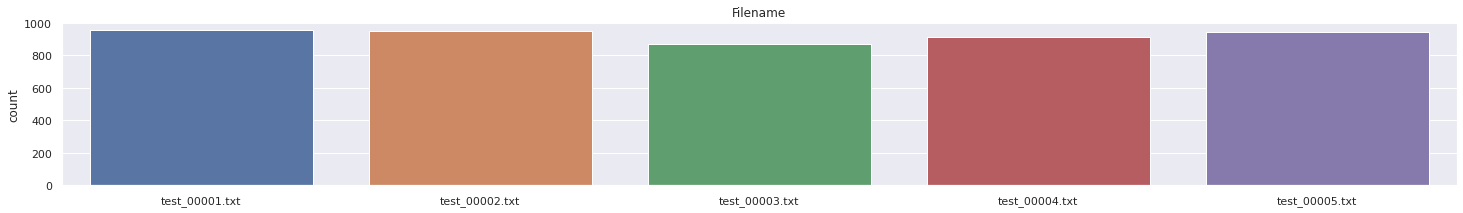

0: 20.63% [  956]
1: 20.48% [  949]
2: 18.80% [  871]
3: 19.75% [  915]
4: 20.35% [  943]

Filename [TRAIN]:


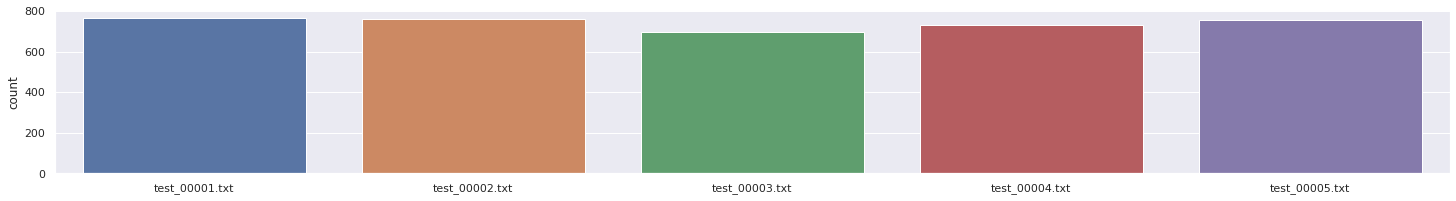


Filename [VALID]:


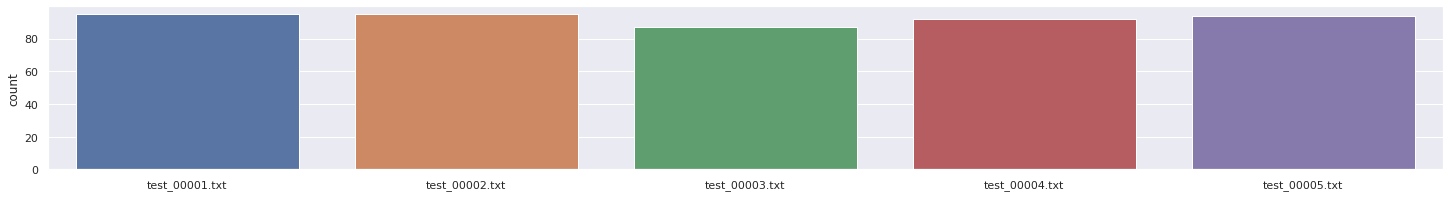


Filename [TEST ]:


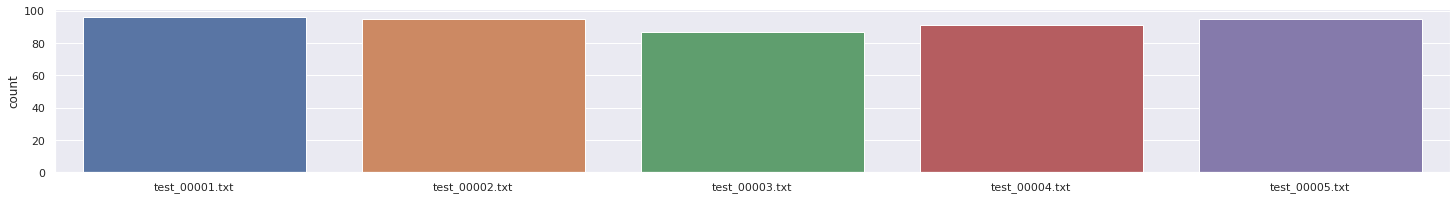

0: Train 20.64% [  765], Valid 20.52% [   95], Test 20.69% [   96]
1: Train 20.47% [  759], Valid 20.52% [   95], Test 20.47% [   95]
2: Train 18.80% [  697], Valid 18.79% [   87], Test 18.75% [   87]
3: Train 19.75% [  732], Valid 19.87% [   92], Test 19.61% [   91]
4: Train 20.34% [  754], Valid 20.30% [   94], Test 20.47% [   95]


,Filename,1,2,3,4,5,6,7,8,9,...,19991,19992,19993,19994,19995,19996,19997,19998,19999,20000
0,test_00002.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,test_00001.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,test_00002.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,test_00002.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,test_00005.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4629,test_00001.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4630,test_00001.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4631,test_00002.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4632,test_00003.txt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Done


In [26]:
#############################
### Data Hyperparameters ####
Seed                = 42 #The answer to Life, the Universe, and Everything.
CustomNAString      = None
batch_size          = 1024
Notes               = []
TrainPerc           = 0.8
ValidPerc           = 0.1
TestPerc            = 1 - TrainPerc - ValidPerc
ShufflePerIteration = True
DependentVarName    = "Filename"
ColumnsToKeepY      = [DependentVarName]
#############################

#############################
### Reading From One File ###
XY_DF = ReadTextLines(f"{path_data}/microbench1.log")
XY_DF = [XY_DF[i][1:-2].replace("'", "") for i in range(len(XY_DF))]

reader = csv.reader(XY_DF, delimiter=',')
Class = []
Feature1 = []
Feature2 = []
for row in reader:
    Class.append(row[0])
    Feature1.append(row[1].strip().split(" "))
    Feature2.append(row[2].strip().split(" "))
Class = np.array(Class)
Feature1 = np.array(Feature1)
Feature2 = np.array(Feature2)

XY_DF = pd.concat([
    pd.DataFrame(Class, columns = ColumnsToKeepY),
    pd.DataFrame(Feature1, columns = [f"{i + 1}" for i in range(Feature1.shape[1])]).astype(np.float32),
    pd.DataFrame(Feature2, columns = [f"{i + 10001}" for i in range(Feature2.shape[1])]).astype(np.float32)
], axis = 1)

XYColumns = XY_DF.columns.values
#################

# ##########################
# ### Viewing the dtypes ###
# print(XY_DF.dtypes.to_string(), "\n")
# ##########################

####################
### Handling NAs ###
Notes += ["Dropping NAs"]
NBeforeCustomNADrop = None
DroppedCustomNARows = None
NBeforeNADrop = len(XY_DF)
XY_DF = XY_DF.dropna().reset_index(drop = True)
DroppedNARows = NBeforeNADrop - len(XY_DF)
if DroppedNARows > 0:
    print(f"Dropped NA rows count: {DroppedNARows} (out of {NBeforeNADrop})")

if CustomNAString is not None:
    NBeforeCustomNADrop = len(XY_DF)
    XY_DF = XY_DF.replace(CustomNAString, np.nan, regex = False).dropna().reset_index(drop = True)
    DroppedCustomNARows = NBeforeCustomNADrop - len(XY_DF)
    if DroppedCustomNARows > 0:
        print(f"Dropped custom NA rows count: {DroppedCustomNARows} (out of {NBeforeCustomNADrop})", )
if DroppedNARows > 0 or (DroppedCustomNARows is not None and DroppedCustomNARows > 0):
    print()
####################

###########################
### Creating an X and Y ###
X_Data = XY_DF.iloc[:, 1:].values
Labels_Data = XY_DF[ColumnsToKeepY].values
###########################

########################
### Integer Encoding ###
Notes += ["Integer Encoding"]
TargetEnc = OrdinalEncoder()
TargetEnc.fit(Labels_Data)

Y_Data = TargetEnc.transform(Labels_Data).astype(np.int64) #The labels
Classes = TargetEnc.categories_[0] #The actual classes names (also maps the numeric values (index of the array) -> original class name)
########################

################################
### Getting a Train/Test set ###
#==Stratified Split
Notes += ["Stratified Split"]
TrainIndx, ValidIndx, TestIndx = train_valid_test_split(np.arange(X_Data.shape[0]), train_size = TrainPerc, valid_size = ValidPerc, Y_Data = None, random_state = Seed, shuffle = True, stratify = Y_Data)
X_Train      =      X_Data[TrainIndx]
Y_Train      =      Y_Data[TrainIndx]
Labels_Train = Labels_Data[TrainIndx]
X_Valid      =      X_Data[ValidIndx]
Y_Valid      =      Y_Data[ValidIndx]
Labels_Valid = Labels_Data[ValidIndx]
X_Test       =      X_Data[TestIndx ]
Y_Test       =      Y_Data[TestIndx ]
Labels_Test  = Labels_Data[TestIndx ]
################################

#####################################
### Creating a Dataset/Dataloader ###
Dataset_Train = TensorDataset(torch.from_numpy(X_Train), torch.from_numpy(Y_Train))
Loader_Train = DataLoader(
    dataset = Dataset_Train,
    batch_size = batch_size,
    shuffle = ShufflePerIteration,
    pin_memory = True,
)

Dataset_Valid = TensorDataset(torch.from_numpy(X_Valid), torch.from_numpy(Y_Valid))
Loader_Valid = DataLoader(
    dataset = Dataset_Valid,
    batch_size = batch_size,
    shuffle = False,
    pin_memory = True,
)

Dataset_Test = TensorDataset(torch.from_numpy(X_Test), torch.from_numpy(Y_Test))
Loader_Test = DataLoader(
    dataset = Dataset_Test,
    batch_size = batch_size,
    shuffle = False,
    pin_memory = True,
)
#####################################

O_Length, K_Length, N_Length, D_Length = Y_Data.shape[1], len(set(Y_Data.squeeze())) if len(Y_Data.squeeze().shape) == 1 else [len(set(Y_Data[:, i])) for i in range(Y_Data.shape[-1])], X_Train.shape[0], X_Train.shape[1]
print(f"X_Data .shape {  X_Data.shape} { X_Data.dtype} | Y_Data.shape  { Y_Data.shape} { Y_Data.dtype}")
print(f"X_Train.shape { X_Train.shape} {X_Train.dtype} | Y_Train.shape {Y_Train.shape} {Y_Train.dtype}")
print(f"X_Valid.shape { X_Valid.shape} {X_Valid.dtype} | Y_Valid.shape {Y_Valid.shape} {Y_Valid.dtype}")
print(f"X_Test .shape {  X_Test.shape} { X_Test.dtype} | Y_Test.shape  { Y_Test.shape} { Y_Test.dtype}")
print(f"X_Data : min = {  X_Data.min():.4f}, max = { X_Data.max():.4f}")
print(f"X_Train: min = {X_Train.min():.4f}, max = {X_Train.max():.4f}")
print(f"X_Valid: min = {X_Valid.min():.4f}, max = {X_Valid.max():.4f}")
print(f"X_Test : min = { X_Test.min():.4f}, max = { X_Test.max():.4f}")
print(f"O_Length: {O_Length} K_Length: {K_Length}")
print(f"N_Length: {N_Length} D_Length: {D_Length}")

plt.rcParams['figure.figsize'] = [25, 3]
print(f"\nPlotting the Dependent Variable:")
sns.countplot(x = sorted(Labels_Data.squeeze()))
plt.title(DependentVarName)
plt.show()

Count = sorted(Counter(Y_Data.squeeze()).items())
FreqKeys = [kv[0] for kv in Count]
FreqData = np.array([kv[1] for kv in Count]) / len(Y_Data) * 100
for i in range(len(FreqData)):
    print(f"{FreqKeys[i]}: {SpaceAString(f'{FreqData[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{Count[i][1]}', MaxLength = 5)}]")

print(f"\n{DependentVarName} [TRAIN]:")
sns.countplot(x = sorted(Labels_Train.squeeze()))
plt.show()

print(f"\n{DependentVarName} [VALID]:")
sns.countplot(x = sorted(Labels_Valid.squeeze()))
plt.show()

print(f"\n{DependentVarName} [TEST ]:")
sns.countplot(x = sorted(Labels_Test.squeeze()))
plt.show()

CountTrain = sorted(Counter(Y_Train.squeeze()).items())
FreqTrain  = np.array([kv[1] for kv in CountTrain]) / len(Y_Train) * 100
CountValid = sorted(Counter(Y_Valid.squeeze()).items())
FreqValid  = np.array([kv[1] for kv in CountValid]) / len(Y_Valid) * 100
CountTest  = sorted(Counter(Y_Test.squeeze()).items())
FreqTest   = np.array([kv[1] for kv in CountTest ]) / len(Y_Test ) * 100

for i in range(len(FreqKeys)):
    print(f"{FreqKeys[i]}: Train {SpaceAString(f'{FreqTrain[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountTrain[i][1]}', MaxLength = 5)}], Valid {SpaceAString(f'{FreqValid[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountValid[i][1]}', MaxLength = 5)}], Test {SpaceAString(f'{FreqTest[i]:.2f}', MaxLength = 5)}% [{SpaceAString(f'{CountTest[i][1]}', MaxLength = 5)}]")
plt.rcParams['figure.figsize'] = OrigFigSize

display(XY_DF) if IsNotebook else print(XY_DF)
print("Done")

# Neural Network

## Hyper Parameters

In [27]:
conv_input_size = X_Train[0].shape if X_Train is not None else X_Data[0].shape

input_size = np.prod(conv_input_size)
output_size = np.prod(O_Length)

print("conv_input_size: " + str(conv_input_size) + ", input_size: " + str(input_size) + ", D_Length: " + str(D_Length) + ", output_size: " + str(output_size))

hn1 = D_Length

ReluAlpha = 0 #0.01 def leakyRelu
EluAlpha = 0.8

layer_type     = ["dense", "dense", "dense"]
###
NUM = 1
#num_units = [hn1, 128, 256, 512, 1024]
num_units = [hn1, 10000, 1024, 128, 64]
###
activation = ["relu"] + ["relu"] * (len(layer_type)-1) #None, "relu6" "relu", "elu", "softplus", "tanh", "sigmoid"
###
dropout    = [0.3] * 1 + [0.3] * (len(layer_type)-1)
###
usebias    = [True] * len(layer_type) + [True]
###
l2_lamda = 0.25
mu = 0.99 #Momentum
###
print()
print("num_units", num_units)
print(f"\nbatch_size: {batch_size}")

conv_input_size: (20000,), input_size: 20000, D_Length: 20000, output_size: 1

num_units [20000, 10000, 1024, 128, 64]

batch_size: 1024


## Optimisation

### Structure

In [28]:
print(device)
Debug = False

model = Net(K_Length, num_units, activation, dropout, usebias)
# if device != "cpu":
#     model = nn.DataParallel(model)
print(model)

#Initialising the Metrics
train_losses, train_metric1s, train_metric2s, train_metric3s, valid_losses, valid_metric1s, valid_metric2s, valid_metric3s = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
train_best_loss, valid_best_loss, valid_best_metric1, valid_best_metric2, valid_best_metric3 = np.Inf, np.Inf, 0, np.nan, np.nan

cuda
Net(
  (layers): ModuleList(
    (0): Linear(in_features=20000, out_features=10000, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=10000, out_features=1024, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=128, bias=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [29]:
print("conv_input_size:", conv_input_size, "\n")
summary(model, input_size = [1, D_Length], device = device, verbose = 1, col_names = ["kernel_size", "input_size", "output_size", "num_params", "mult_adds"], depth = 3)

if IS_GPU_AVAILABLE:
    torch.cuda.empty_cache()

conv_input_size: (20000,) 

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
Net                                      --                        [1, 20000]                [1, 5]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --                        --
│    └─Linear: 2-1                       --                        [1, 20000]                [1, 10000]                200,010,000               200,010,000
│    └─Dropout: 2-2                      --                        [1, 10000]                [1, 10000]                --                        --
│    └─ReLU: 2-3                         --                        [1, 10000]                [1, 10000]                --                        --
│    └─Linear: 2-4                       --                        [

In [30]:
#Setting the Loss Function and Optimisation technique
criterion = nn.CrossEntropyLoss() #Using Categorical Cross Entropy loss function
print(criterion.__class__.__name__)
print("Multiclass Classification")

learning_rate = 1e-2
optimiser = torch.optim.AdamW(model.parameters(), lr = learning_rate, betas = (mu, 0.999), weight_decay = l2_lamda, amsgrad = False)

CrossEntropyLoss
Multiclass Classification


In [31]:
# for prm_grp in optimiser.param_groups:
#     prm_grp['lr'] = 1e-4
# #     prm_grp['weight_decay'] = 0.1

### Stochastic Gradient Descent (Dataset)

In [32]:
Epochs = int(100)
PrintInfoEverynEpochs = 1
scheduler = None
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size = Epochs // 10 if Epochs > 10 else 3, gamma = 0.8)

new_train_losses, new_valid_losses, train_best_loss, valid_best_loss, new_train_metric1s, new_train_metric2s, new_train_metric3s, new_valid_metric1s, new_valid_metric2s, new_valid_metric3s,\
Metric1, Metric2, Metric3, valid_best_metric1, valid_best_metric2, valid_best_metric3, elapsed_time = \
    batch_gd(model, device, criterion, optimiser, scheduler, Loader_Train, Loader_Valid, epochs = Epochs, PrintInfoEverynEpochs = PrintInfoEverynEpochs,
             train_best_loss = train_best_loss, test_best_loss = valid_best_loss, BestMetric1 = valid_best_metric1, BestMetric2 = valid_best_metric2, BestMetric3 = valid_best_metric3,
             Verbose = False
    )

train_losses, valid_losses = np.append(train_losses, new_train_losses), np.append(valid_losses, new_valid_losses)
train_metric1s, train_metric2s, train_metric3s = np.append(train_metric1s, new_train_metric1s), np.append(train_metric2s, new_train_metric2s), np.append(train_metric3s, new_train_metric3s)
valid_metric1s, valid_metric2s, valid_metric3s = np.append(valid_metric1s, new_valid_metric1s), np.append(valid_metric2s, new_valid_metric2s), np.append(valid_metric3s, new_valid_metric3s)
train_loss, valid_loss, valid_metric1, valid_metric2, valid_metric3 = LastNonNan(new_train_losses), LastNonNan(new_valid_losses), Metric1, Metric2, Metric3

print(f'\ntrain_best_loss: {train_best_loss:.5f}, valid_best_loss: {valid_best_loss:.5f}, Acc: {valid_metric1:.5f}, AUC: {valid_metric2:.5f}, F1: {valid_metric3:.5f}')

if IS_GPU_AVAILABLE:
    torch.cuda.empty_cache()
if IsWindows:
    winsound.PlaySound('SystemExit', winsound.SND_NOSTOP)

Epoch 001/100, Train Loss: 10.2324, Test Loss: 1.6099 | Acc: 0.289, AUC: 0.555, F1: 0.203, Duration: 0:00:00.854980
Epoch 002/100, Train Loss:  1.6009, Test Loss: 1.5829 | Acc: 0.395, AUC: 0.682, F1: 0.277, Duration: 0:00:00.580518
Epoch 003/100, Train Loss:  1.4496, Test Loss: 1.4507 | Acc: 0.404, AUC: 0.730, F1: 0.283, Duration: 0:00:00.442236
Epoch 004/100, Train Loss:  1.2851, Test Loss: 1.4395 | Acc: 0.402, AUC: 0.702, F1: 0.326, Duration: 0:00:00.447771
Epoch 005/100, Train Loss:  1.1909, Test Loss: 1.4394 | Acc: 0.413, AUC: 0.715, F1: 0.342, Duration: 0:00:00.430895
Epoch 006/100, Train Loss:  1.1552, Test Loss: 1.4386 | Acc: 0.400, AUC: 0.742, F1: 0.283, Duration: 0:00:00.437013
Epoch 007/100, Train Loss:  1.4088, Test Loss: 1.4352 | Acc: 0.402, AUC: 0.753, F1: 0.284, Duration: 0:00:00.450955
Epoch 008/100, Train Loss:  1.1376, Test Loss: 1.4319 | Acc: 0.447, AUC: 0.745, F1: 0.389, Duration: 0:00:00.451790
Epoch 009/100, Train Loss:  1.1112, Test Loss: 1.4288 | Acc: 0.438, AUC:

In [33]:
#Loading the best trained model (in case the last one was overfitted)

model.load_state_dict(torch.load("model_dict.pt"))
model.eval()
train_loss = train_best_loss
valid_loss = valid_best_loss
valid_metric1 = valid_best_metric1
valid_metric2 = valid_best_metric2
valid_metric3 = valid_best_metric3

# Evaluation

## Training Metrics

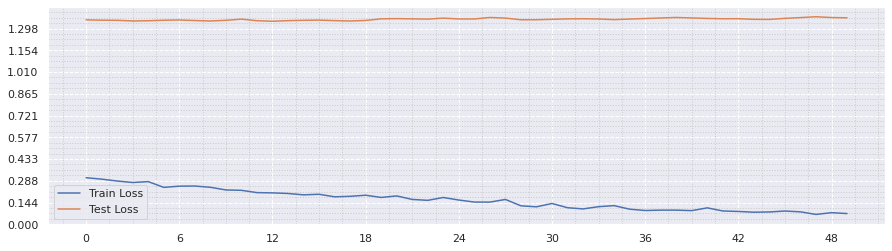

In [34]:
PlotHistory(train_losses[-(50):], valid_losses[-(50):], figsize=(15, 4), test_alpha = 1)

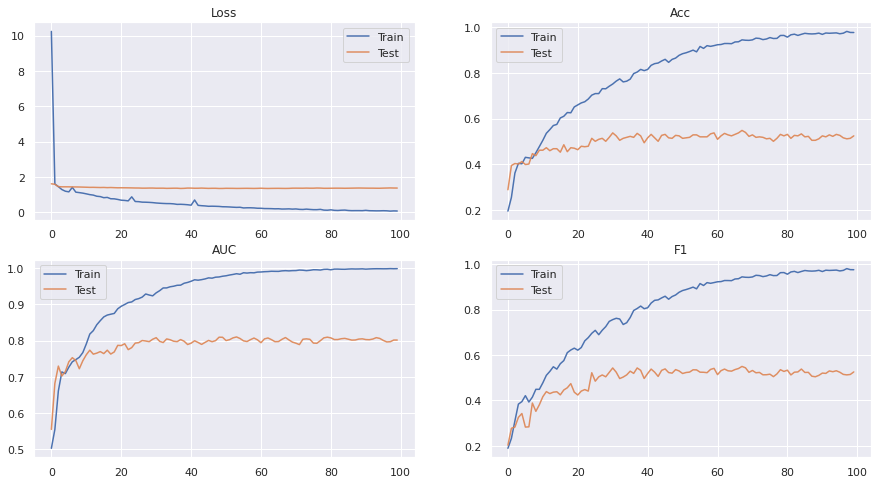

In [35]:
PlotAllMetrics(["Loss", "Acc", "AUC", "F1"],
               [train_losses, train_metric1s, train_metric2s, train_metric3s],
               TestMetrics = [valid_losses, valid_metric1s, valid_metric2s, valid_metric3s],
               figsize = [15, 8], test_alpha = 0.90)

## Multiclass Classification

Sample-wise Acc: 51.51%, AUC: 0.80, F1: 0.52
Class-wise  Acc: 80.60%, Recall: 0.515, Precision: 0.562

Confusion matrix
[[94  1  1  0  0]
 [ 0 33 49  9  4]
 [ 0 11 45 18 13]
 [ 1  3 35 37 15]
 [ 0  6 34 25 30]]


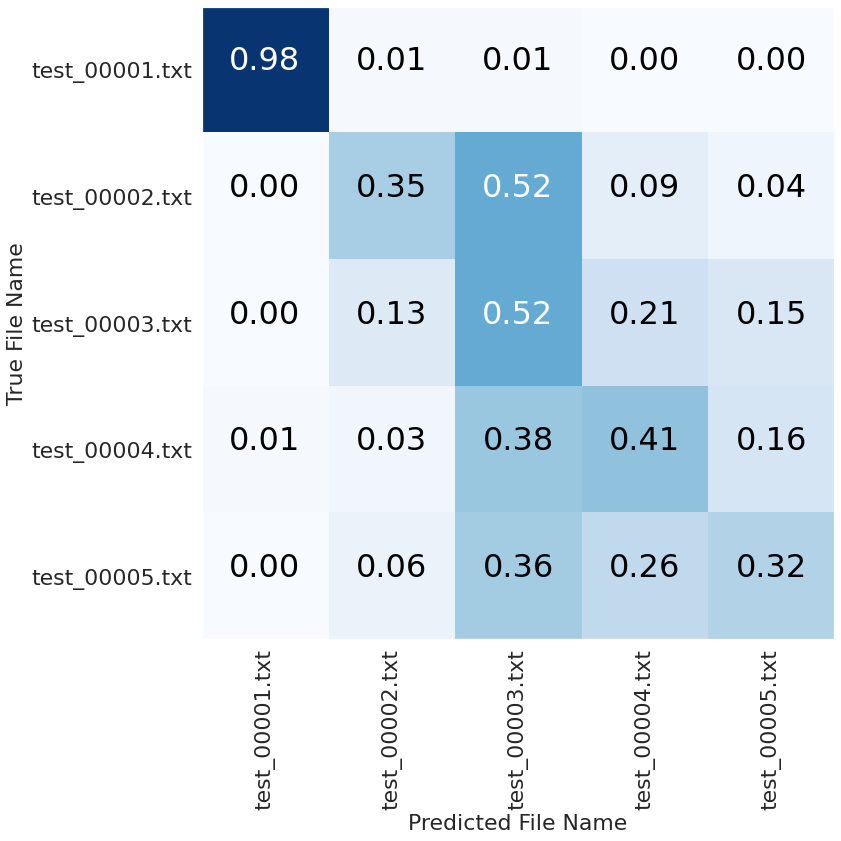


Class test_00001.txt. Acc: 0.994, Recall: 0.979, Precision: 0.989, F1: 0.984
Class test_00002.txt. Acc: 0.821, Recall: 0.347, Precision: 0.611, F1: 0.443
Class test_00003.txt. Acc: 0.653, Recall: 0.517, Precision: 0.274, F1: 0.359
Class test_00004.txt. Acc: 0.772, Recall: 0.407, Precision: 0.416, F1: 0.411
Class test_00005.txt. Acc: 0.791, Recall: 0.316, Precision: 0.484, F1: 0.382

Per Class ROC:


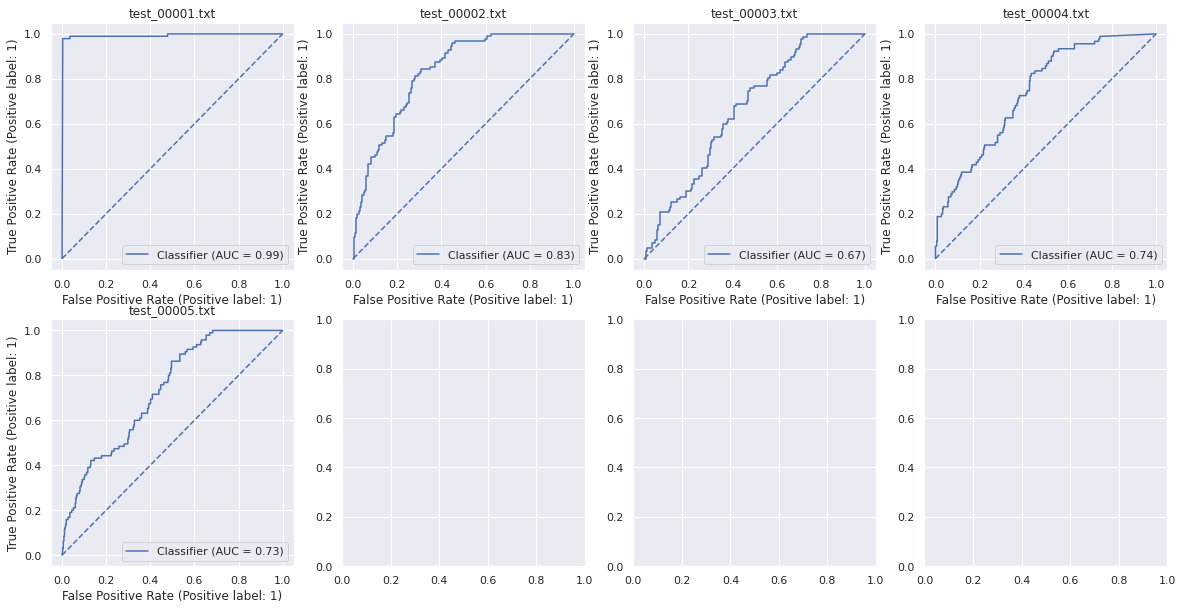


Per Class Precision-Recall Curve:


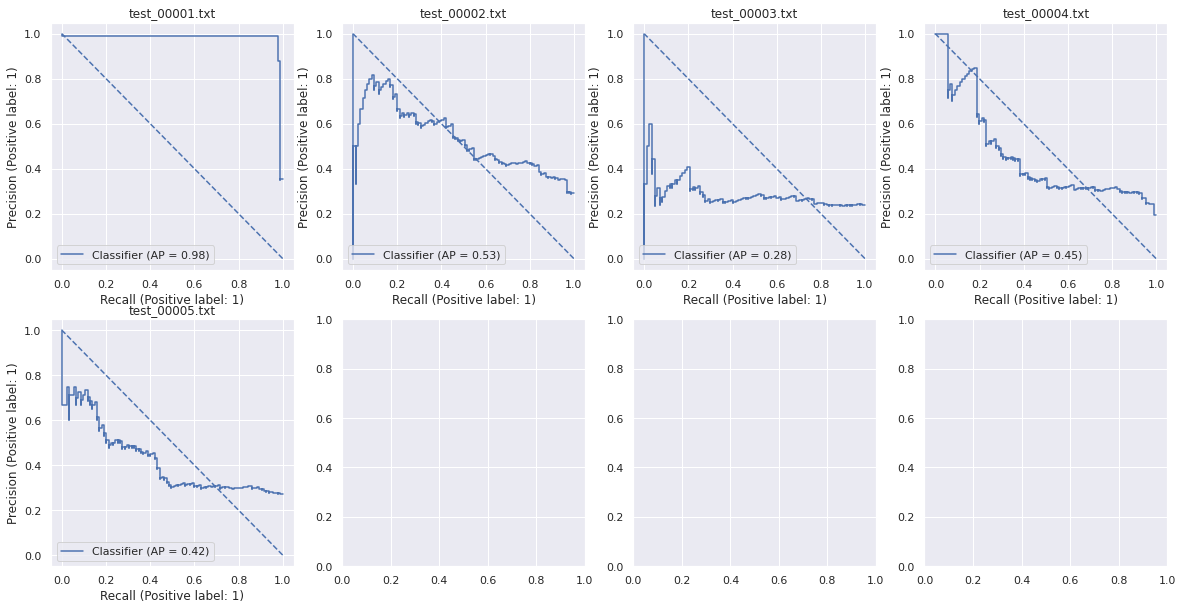

In [54]:
Labels = Classes
MaxLabelsLen = max([len(lbl) for lbl in Labels])
with torch.no_grad(): #Making sure that we don't update the gradient outside the training part
        model.eval() #Putting model in evaluation mode so that things like dropout() are deactivated
        model.to(device) #Moving the model to the appropriate device (CPU/CUDA/etc.)
        
        #Using the Forward direction of the model to get the Predictions (also returning the corresponding Targets in case there's suffling and X_Test isn't indexed the same)
        Preds_prob, Preds, Targets = EvalPredict(model, device, Loader_Test)

test_Acc, test_AUC, test_F1 = GetCategoricalMetrics(Preds_prob, Preds, Targets)
print(f'Sample-wise Acc: {test_Acc * 100:.2f}%, AUC: {test_AUC:.2f}, F1: {test_F1:.2f}')
print(f"Class-wise  Acc: {ClassAccMulti(Targets, Preds, K_Length) * 100:.2f}%, Recall: {recall_score(Targets, Preds, average = 'weighted'):.3f}, Precision: {precision_score(Targets, Preds, average = 'weighted'):.3f}\n") #'micro', 'macro', 'weighted', 'samples'

#Viewing the overall Categorical metrics and Plotting the Confusion Matrix
PlotCategoricalMetrics(Preds, Targets, Labels, Normalise = True, figsize = [11, 11])
print("")

plt.rcParams['figure.figsize'] = [5, 5]
TrueClasses, PerClassAccuracy, PerClassAUC, PerClassF1 = [], [], [], []
for k in range(K_Length):
    PredClass = Preds.squeeze()   == k
    TrueClass = Targets.squeeze() == k
    TrueClasses.append(TrueClass)
    cur_test_Acc, cur_test_AUC, cur_test_F1 = GetCategoricalMetrics(Preds_prob[:, k], PredClass, TrueClass, Verbose = True)
    PerClassAccuracy.append(cur_test_Acc)
    PerClassAUC.append(cur_test_AUC)
    PerClassF1.append(cur_test_F1)
    print(f"Class {SpaceAString(Labels[k], MaxLabelsLen)}. Acc: {np.mean(TrueClass == PredClass):.3f}, Recall: {recall_score(TrueClass, PredClass):.3f}, Precision: {precision_score(TrueClass, PredClass):.3f}, F1: {f1_score(TrueClass, PredClass):.3f}")
PerClassAccuracy, PerClassAUC, PerClassF1 = np.array(PerClassAccuracy), np.array(PerClassAUC), np.array(PerClassF1)

# Marina commented out
#print("\nPer Class Metrics:")
#PlotPerClassMetrics(K_Length, PerClassAccuracy, PerClassAUC, PerClassF1, Labels = Labels)

print("\nPer Class ROC:")
PlotPerClassROCCurve(K_Length, TrueClasses, Preds_prob, Labels = Labels)

print("\nPer Class Precision-Recall Curve:")
PlotPerClassPRCurve(K_Length, TrueClasses, Preds_prob, Labels = Labels)

plt.rcParams['figure.figsize'] = OrigFigSize
#Sample-wise Acc: 67.06%, AUC: 0.95, F1: 0.65


In [37]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 03:37:44
